# Setup de pacotes utilizados

In [1]:
import pandas
!pip install radon
import radon

# Geração de notas de qualidade dos códigos

In [2]:
submissions_path = '/content/submissions.csv'

submissions_df = pandas.read_csv(submissions_path)

submissions_df

,problem_id,submission_id,code
0,4A,269308927,w = int(input())\r\nif w%2 == 0 and w != 2:\r\...
1,4A,268967990,def main():\r\n watermelon = int(input())\r...
2,4A,4278977,n = int(input())\r\nanswer = 'YES' if n > 2 an...
3,4A,204115614,print('YNEOS'[5%~int(input())%2::2])
4,4A,143412806,"# x,y=[int(i)for i in input().split()]\r\n# a,..."
...,...,...,...
145,624A,77988853,"a,b,c,d=map(int,input().split())\r\nprint((b-a..."
146,624A,113002034,"d,l,a,b=map(int,input().split())\r\na=(l-d)/(a..."
147,624A,117302304,"d,L,v1,v2=map(int,input().split())\r\nprint(f'..."
148,624A,232308516,"import math\r\n\r\nd, L, v1, v2 = map(int, inp..."


In [3]:
from radon.metrics import h_visit, mi_visit

def calculate_metrics(submission):
  source_code = submission['code']

  effort = h_visit(source_code).total.effort
  modularity = mi_visit(str(source_code), multi = True)

  return {
    'halstead_effort': effort,
    'modularity_score': modularity,
  }

submissions_df[['halstead_effort', 'modularity_score']] = submissions_df.apply(calculate_metrics, axis = 1, result_type = 'expand')

submissions_df.head()

,problem_id,submission_id,code,halstead_effort,modularity_score
0,4A,269308927,w = int(input())\r\nif w%2 == 0 and w != 2:\r\...,106.301699,73.141962
1,4A,268967990,def main():\r\n watermelon = int(input())\r...,134.436094,67.644501
2,4A,4278977,n = int(input())\r\nanswer = 'YES' if n > 2 an...,192.051563,77.071070
3,4A,204115614,print('YNEOS'[5%~int(input())%2::2]),22.458839,83.836408
4,4A,143412806,"# x,y=[int(i)for i in input().split()]\r\n# a,...",106.301699,39.837155


Distribuição de scores para modularidade (numa escala de 0 a 100).

Text(0, 0.5, 'Frequência absoluta')

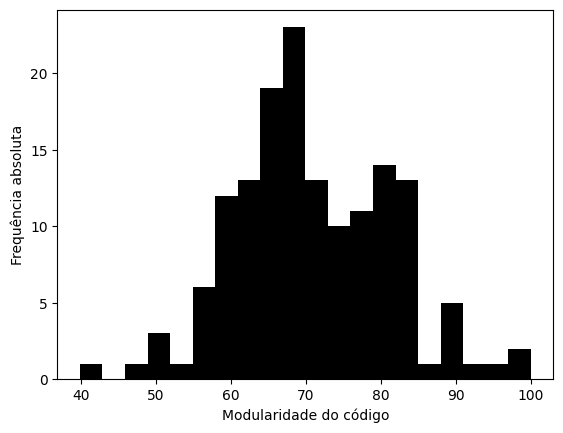

In [4]:
from matplotlib import pyplot as plt

submissions_df['modularity_score'].plot(kind = 'hist', bins = 20, colormap = 'gray')
plt.gca().set_xlabel('Modularidade do código')
plt.gca().set_ylabel('Frequência absoluta')

Distribuição de esforço.

Text(0, 0.5, 'Frequência absoluta')

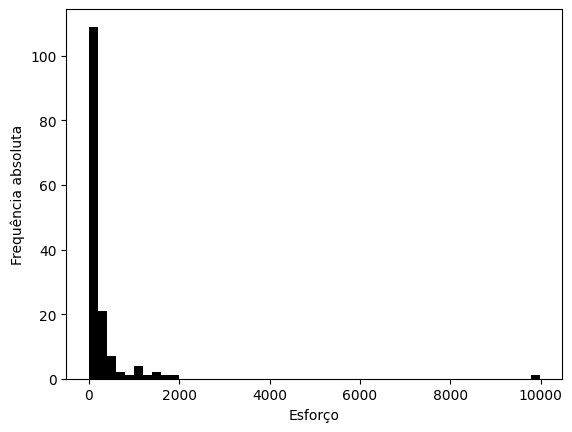

In [5]:
submissions_df['halstead_effort'].plot(kind = 'hist', bins = 50, cmap = 'gray')
plt.gca().set_xlabel('Esforço')
plt.gca().set_ylabel('Frequência absoluta')

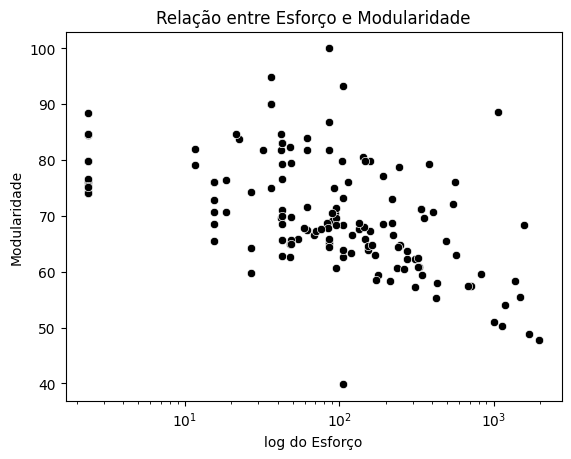

In [6]:
import seaborn as sns

# Remoção de outliers de esforço.
effort_df = submissions_df[submissions_df['halstead_effort'] < 9000]
effort_df = effort_df[effort_df['halstead_effort'] > 0]

sns.scatterplot(data = effort_df, x = 'halstead_effort', y = 'modularity_score', color = 'black')
plt.xscale('log')
plt.xlabel('log do Esforço')
plt.ylabel('Modularidade')
plt.title('Relação entre Esforço e Modularidade')
plt.show()

# Análise dos resultados

In [7]:
file_path = '/content/grades.csv'

df = pandas.read_csv(file_path)

df.head()

,submission_id,quality_score,functionality_score
0,269308927,4,1
1,268967990,4,1
2,4278977,4,1
3,204115614,4,0
4,143412806,3,0


Text(0, 0.5, 'Frequência absoluta')

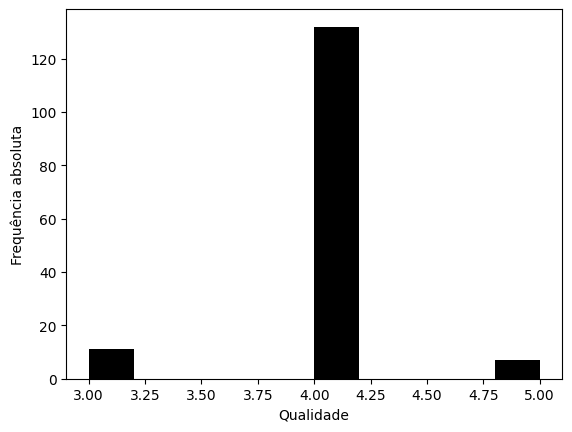

In [8]:
df['quality_score'].plot(kind = 'hist', cmap = 'gray')
plt.gca().set_xlabel('Qualidade')
plt.gca().set_ylabel('Frequência absoluta')

In [9]:
merged_df = submissions_df.merge(df, on = 'submission_id')

merged_df['verdict'] = [x // 5 for x in range(9, -1, -1)] * 15 # Questões alternam entre 5 corretas e 5 erradas.

merged_df.head()

,problem_id,submission_id,code,halstead_effort,modularity_score,quality_score,functionality_score,verdict
0,4A,269308927,w = int(input())\r\nif w%2 == 0 and w != 2:\r\...,106.301699,73.141962,4,1,1
1,4A,268967990,def main():\r\n watermelon = int(input())\r...,134.436094,67.644501,4,1,1
2,4A,4278977,n = int(input())\r\nanswer = 'YES' if n > 2 an...,192.051563,77.071070,4,1,1
3,4A,204115614,print('YNEOS'[5%~int(input())%2::2]),22.458839,83.836408,4,0,1
4,4A,143412806,"# x,y=[int(i)for i in input().split()]\r\n# a,...",106.301699,39.837155,3,0,1


In [10]:
import numpy as np
from scipy.stats import spearmanr

def bootstrap_spearman(x, y, n_bootstrap = 2000, ci = 0.95):
    n = len(x)
    rs = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(n, n, replace = True)
        x_sample = np.array(x)[indices]
        y_sample = np.array(y)[indices]
        r, _ = spearmanr(x_sample, y_sample)
        rs.append(r)
    rs = np.array(rs)
    lower_bound = np.percentile(rs, (1 - ci)/2 * 100)
    upper_bound = np.percentile(rs, (1 + ci)/2 * 100)
    return np.mean(rs), lower_bound, upper_bound

In [11]:
bootstrap_spearman(merged_df['modularity_score'], merged_df['quality_score'])

(0.020450161814905266, -0.2131000430486278, 0.2590744304491611)

In [12]:
bootstrap_spearman(merged_df['functionality_score'], merged_df['verdict'])

(0.38281927984488984, 0.24591801604327443, 0.5132466136518992)

In [13]:
bootstrap_spearman(merged_df['halstead_effort'], merged_df['modularity_score'])

(-0.594868627948651, -0.7012384141462902, -0.4675884199576307)

In [14]:
from sklearn.metrics import accuracy_score

group_by_problem = merged_df.groupby('problem_id')

accuracy_by_problem = group_by_problem.apply(lambda x: accuracy_score(x['verdict'], x['functionality_score']))
accuracy_by_problem

problem_id
104A    0.5
146A    0.9
233A    0.8
268A    0.5
32A     0.6
386A    0.4
401A    0.6
448A    0.6
467A    0.7
492A    0.6
4A      0.8
520A    0.7
599A    0.5
59A     0.8
624A    0.9
dtype: float64

Geração de matriz de confusão.

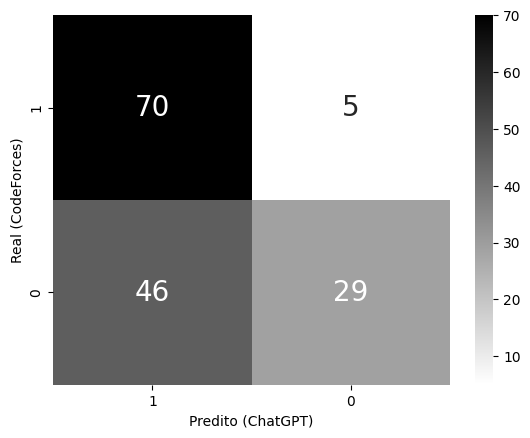

In [15]:
cm = pandas.crosstab(merged_df['verdict'], merged_df['functionality_score'])

ax = sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'gray_r', annot_kws = { 'size': 20 })
ax.invert_yaxis()
ax.invert_xaxis()
# ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real (CodeForces)')
ax.set_xlabel('Predito (ChatGPT)')
plt.show()

In [16]:
false_positives = merged_df[(merged_df['functionality_score'] == 1) & (merged_df['verdict'] == 0)]
false_negatives = merged_df[(merged_df['functionality_score'] == 0) & (merged_df['verdict'] == 1)]

In [17]:
false_positives

,problem_id,submission_id,code,halstead_effort,modularity_score,quality_score,functionality_score,verdict
16,32A,137964971,"n,d = map(eval,input().split())\r\nlist_1 = li...",134.436094,67.644501,4,1,0
17,32A,107136237,"n,d = map(int,input().split())\r\nlist_=sorted...",89.624063,69.044038,4,1,0
18,32A,58950256,"n,d = map(int,input().split())\r\nl = sorted(l...",223.872469,66.572789,4,1,0
19,32A,46680942,"n, d = map(int, input().split())\na = [int(i) ...",83.259894,68.678623,4,1,0
25,59A,4286521,import sys\r\nmy_file = sys.stdin\r\n#my_file ...,41.794706,81.813196,4,1,0
27,59A,177781379,s=input()\r\nprint(s.lower()),0.000000,100.000000,4,1,0
35,104A,169976018,n=int(input())\r\ndif=n-10\r\nif dif>=2 and di...,249.779681,64.745169,4,1,0
36,104A,82025698,n = int(input())\r\nr = n-10\r\nif r<=0:\r\n ...,121.725120,66.583231,4,1,0
37,104A,233720349,import math\r\nn = int(input())\r\nif n == 20:...,59.596154,67.794501,4,1,0
38,104A,166294041,n = int(input())\r\n\r\ncard_value = n - 10 # ...,106.301699,93.303101,4,1,0
